In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from sklearn.ensemble import RandomForestRegressor
from IPython.core.display import display,HTML
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.tree import DecisionTreeRegressor
import joblib
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers
from keras import regularizers
from fancyimpute import KNN

In [2]:
#import xgboost as xgb
#pip install xgboost

In [3]:
import xgboost
from xgboost import XGBRegressor

In [4]:
train=pd.read_csv('https://raw.githubusercontent.com/datascience-enthusiast/Cab-Fare-Prediction/master/train_cab.csv',na_values={'fare_amount':'430-'})
test=pd.read_csv('https://raw.githubusercontent.com/datascience-enthusiast/Cab-Fare-Prediction/master/test.csv')

In [5]:
#pickup_datetime - timestamp value indicating when the cab ride started.
#pickup_longitude - float for longitude coordinate of where the cab ride started.
#pickup_latitude - float for latitude coordinate of where the cab ride started.
#dropoff_longitude - float for longitude coordinate of where the cab ride ended.
#dropoff_latitude - float for latitude coordinate of where the cab ride ended.
#passenger_count - an integer indicating the number of passengers in the cabride

# Understanding the data

In [6]:
print(train.shape,test.shape)

(16067, 7) (9914, 6)


In [7]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [8]:
test.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [9]:
# as seen from the above 2 datasets we have 6 independent variables and 1 dependent variables in the train dataset and the

In [10]:
# converting  pickup datetime to datetime
#train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC")

In [11]:
train=train.drop(train[train['pickup_datetime']=='43'].index,axis=0)
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format="%Y-%m-%d %H:%M:%S UTC",errors='coerce')

In [12]:
test['passenger_count']=test['passenger_count'].astype(float)

In [13]:
train['fare_amount']=train['fare_amount'].astype(float)

# Missing Values Analysis

In [14]:
print(train.isnull().sum(),test.isnull().sum())

fare_amount          25
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
passenger_count      55
dtype: int64 pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [15]:
train = train.drop(train[train.isnull().any(1)].index, axis = 0)

In [16]:
train.shape

(15986, 7)

In [17]:
train['fare_amount'].describe()

count    15986.000000
mean        15.030453
std        431.213944
min         -3.000000
25%          6.000000
50%          8.500000
75%         12.500000
max      54343.000000
Name: fare_amount, dtype: float64

In [18]:
#we check for any negative values in the fare_amount
from collections import Counter
Counter(train['fare_amount']<=0)

Counter({False: 15982, True: 4})

In [19]:
train = train.drop(train[train['fare_amount']<0].index, axis = 0) #3 observations dropped
train = train.drop(train[train['fare_amount']== 0].index, axis = 0) #1 observations dropped
train.shape

(15982, 7)

In [20]:
#from this we see that the max value in the fare column in 54343 which doesn't make any sense
train['fare_amount'].sort_values(ascending = False)

1015    54343.00
1072     4343.00
607       453.00
980       434.00
1335      180.00
          ...   
9773        2.50
8603        2.50
8596        2.50
1427        1.14
2780        0.01
Name: fare_amount, Length: 15982, dtype: float64

In [21]:
train=train.drop(train[train['fare_amount']==54343].index,axis=0)
train=train.drop(train[train['fare_amount']==4343].index,axis=0)
#After Checking highest fare_amount, fount that there 3 values which are highest and not possible in fare_amount
train=train.drop(train[train['fare_amount']==0.01].index,axis=0)

In [22]:
train.shape

(15979, 7)

In [23]:
train['passenger_count'].sort_values(ascending=False)

1146     5345.0
293      5334.0
8985      557.0
971       554.0
8506      537.0
          ...  
9965        0.0
3034        0.0
3481        0.0
15919       0.0
11803       0.0
Name: passenger_count, Length: 15979, dtype: float64

In [24]:
train=train.drop(train[train['passenger_count']>10].index,axis=0)

In [25]:
train['passenger_count'].sort_values(ascending=True)

5517     0.0
9965     0.0
12611    0.0
3481     0.0
3034     0.0
        ... 
392      6.0
10361    6.0
13692    6.0
373      6.0
12363    6.0
Name: passenger_count, Length: 15960, dtype: float64

In [26]:
#now deleting the passenger counts which are in 0's and in decimals as these are outliers
train=train.drop(train[train['passenger_count']==0].index,axis=0)

In [27]:
train['passenger_count'].sort_values(ascending=True)

8862     0.12
0        1.00
9797     1.00
9798     1.00
9801     1.00
         ... 
5019     6.00
7455     6.00
10657    6.00
8459     6.00
8881     6.00
Name: passenger_count, Length: 15903, dtype: float64

In [28]:
# we found value 0.12 which is also a outlier dropping it
train=train.drop(train[train['passenger_count']==0.12].index,axis=0)

# New York City Latitude and longitude coordinates are: 40.730610, -73.935242.

In [29]:
#Latitude ranges from 39 to 43 ,#Longitude ranges from -72 to -76,#so dropping all the other regions
train = train.drop(train[train['pickup_latitude']<39].index, axis=0) 

In [30]:
train = train.drop(train[train['pickup_latitude']>43].index, axis=0)

In [31]:
print(train['pickup_latitude'].describe(),train['pickup_longitude'].describe())

count    15583.000000
mean        40.750923
std          0.038016
min         39.603178
25%         40.736592
50%         40.753368
75%         40.767805
max         41.366138
Name: pickup_latitude, dtype: float64 count    15583.000000
mean       -73.974797
std          0.041558
min        -74.438233
25%        -73.992373
50%        -73.982049
75%        -73.968079
max        -73.137393
Name: pickup_longitude, dtype: float64


In [32]:
train = train.drop(train[train['pickup_longitude']>-72].index, axis=0) 
train = train.drop(train[train['pickup_longitude']<-76].index, axis=0) 
train = train.drop(train[train['dropoff_latitude']<39].index, axis=0)
train = train.drop(train[train['dropoff_latitude']>43].index, axis=0)
train = train.drop(train[train['dropoff_longitude']>-72].index, axis=0)
train = train.drop(train[train['dropoff_longitude']<-76].index, axis=0)

In [33]:
train.shape

(15570, 7)

# Feature Selection

In [34]:
#correlation matrix to understand how the each variable related with each other
corr=train.corr()
corr

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
fare_amount,1.000000,0.298960,-0.131786,0.252538,-0.105001,0.004734
pickup_longitude,0.298960,1.000000,0.196346,0.390560,0.154156,-0.004675
pickup_latitude,-0.131786,0.196346,1.000000,0.158357,0.505780,-0.003151
dropoff_longitude,0.252538,0.390560,0.158357,1.000000,0.260921,-0.007609
dropoff_latitude,-0.105001,0.154156,0.505780,0.260921,1.000000,-0.003112
passenger_count,0.004734,-0.004675,-0.003151,-0.007609,-0.003112,1.000000


C:\Users\lalit\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


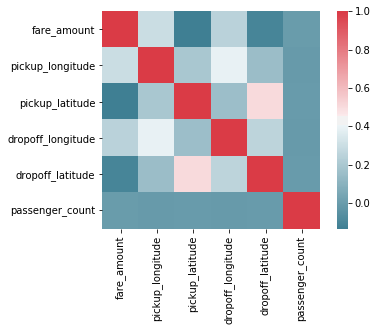

In [35]:
# we see that each variable in dataset is independent and not correlated with each other. So, each variable or feature play an important role to predict the fare_amount
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),cmap = sns.diverging_palette(220,10,as_cmap=True),square =True)

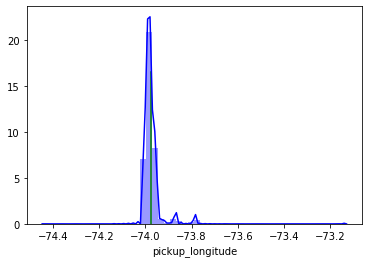

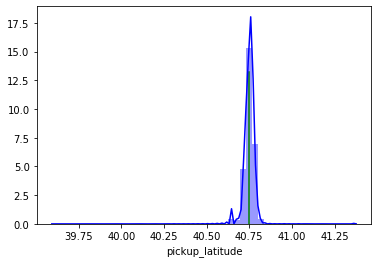

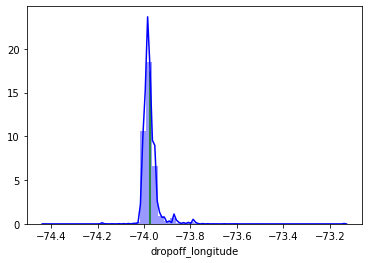

In [36]:
continous_columns=['pickup_longitude','pickup_latitude','dropoff_longitude']
for i,col in enumerate(continous_columns):
    plt.figure(i)
    plt.axvline(train[col].mean(),0,0.7,color='g')
    sns.distplot(train[col],color='b')

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\lalit\anaconda3\lib\site-packages\seaborn\categorical.py:3675: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


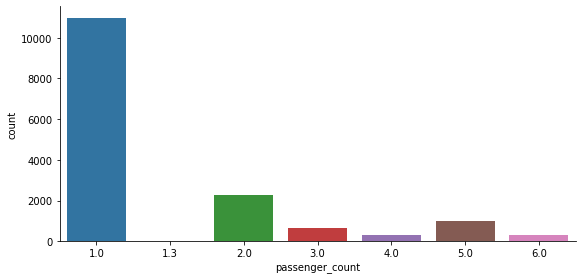

In [37]:
category_columns_names=['passenger_count']
for i in category_columns_names:
    sns.factorplot(data=train,x=i,kind='count',size=4,aspect=2)

Text(0.5, 1.0, 'Histogram for Fare and people')

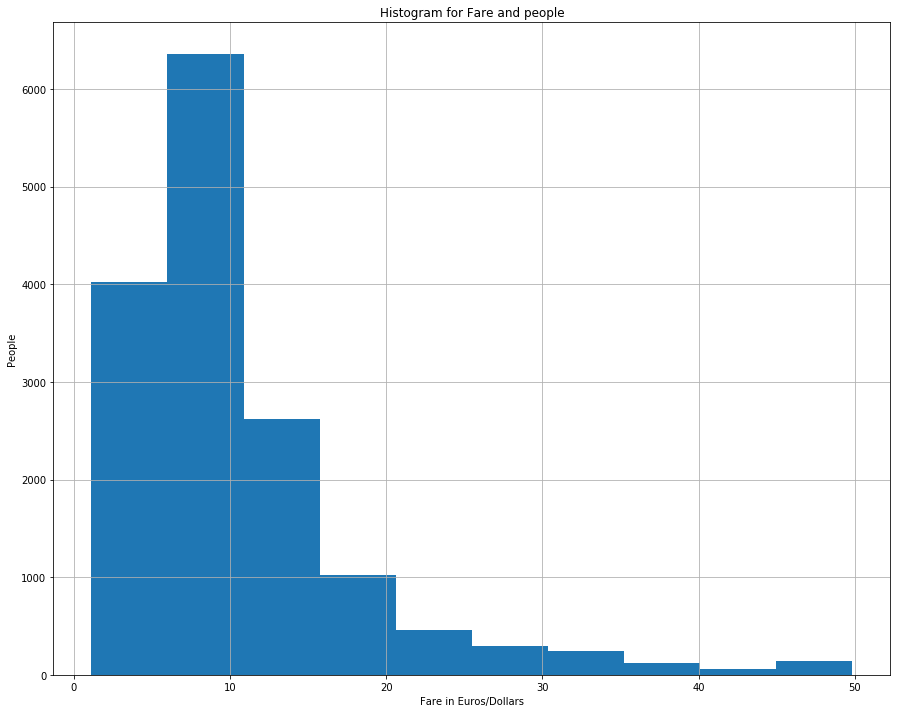

In [38]:
train[train['fare_amount']<50].fare_amount.hist(figsize=(15,12))
plt.xlabel('Fare in Euros/Dollars')
plt.ylabel('People')
plt.title('Histogram for Fare and people')

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


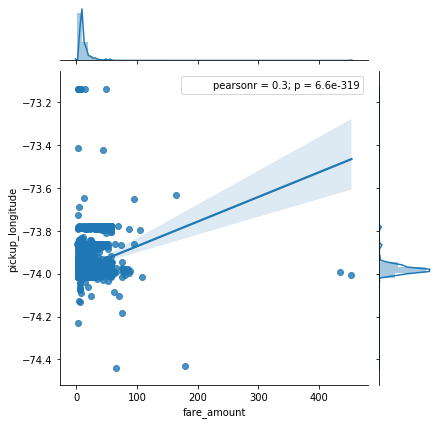

In [39]:
a= sns.jointplot(x='fare_amount',y='pickup_longitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfplo.png')
plt.show()

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


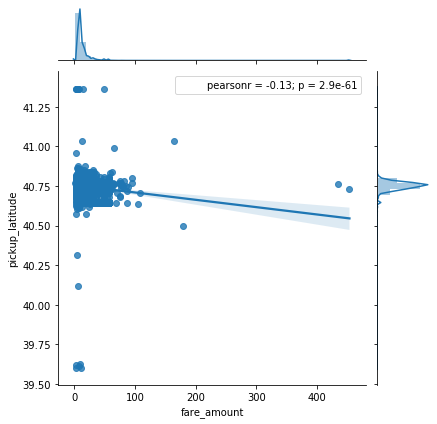

In [40]:
a= sns.jointplot(x='fare_amount',y='pickup_latitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfpla.png')
plt.show()

C:\Users\lalit\anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


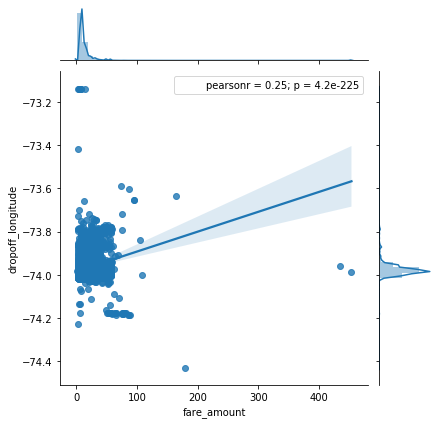

In [41]:
a= sns.jointplot(x='fare_amount',y='dropoff_longitude',data=train,kind = 'reg')
a.annotate(stats.pearsonr)
# plt.savefig('jointfdlo.png')
plt.show()

# Exploratory Data Analysis

In [42]:
#Does the passenger_count (Number of Passengers) affect the fare_amount (fare)?
#Does the pickup_datetime (Pickup Date & Time) affect the fare_amount (fare)?
#Does the day of the week affect the fare_amount (fare)?
#Does the distance travelled affect the fare_amount (fare)?

In [43]:
for i in range(4,11):
    print('passenger count above '+str(i)+'={}'.format(sum(train['passenger_count']>i)))

passenger count above 4=1318
passenger count above 5=294
passenger count above 6=0
passenger count above 7=0
passenger count above 8=0
passenger count above 9=0
passenger count above 10=0


In [44]:
train['pickup_datetime'] = train['pickup_datetime'].dt.strftime('%Y-%m-%d %H:%M:%S UTC')

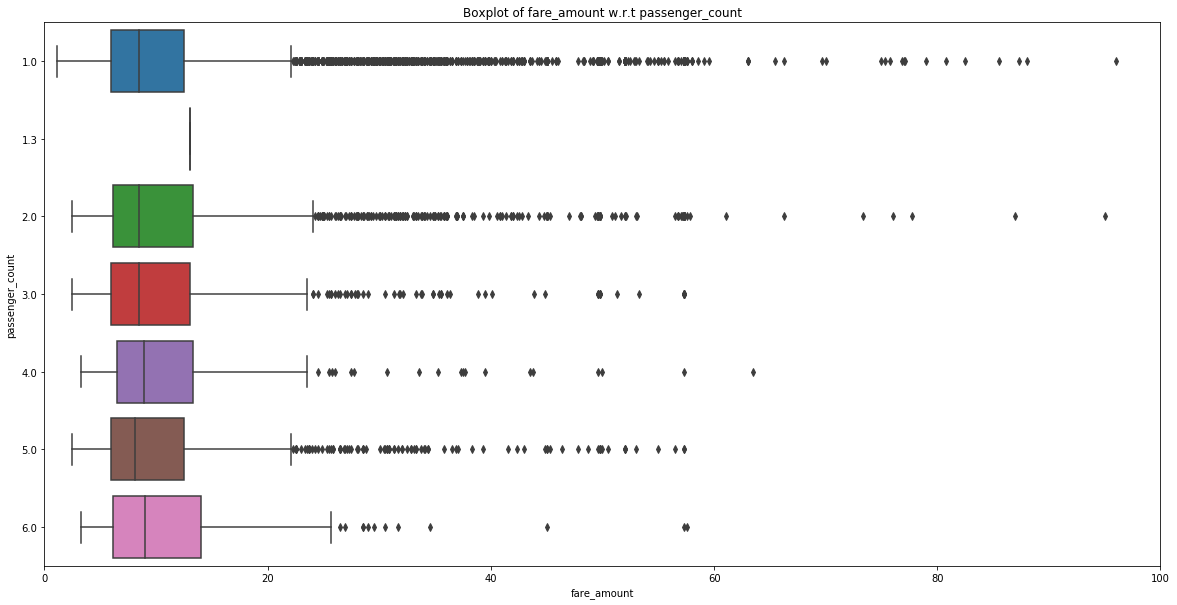

In [45]:
#bivariate analysis
plt.figure(figsize=(20,10))
plt.xlim(0,100)
a= sns.boxplot(x=train['fare_amount'],y=train['passenger_count'],data=train,orient='h')
plt.title('Boxplot of fare_amount w.r.t passenger_count')
# plt.savefig('Boxplot of fare_amount w.r.t passenger_count.png')
plt.show()

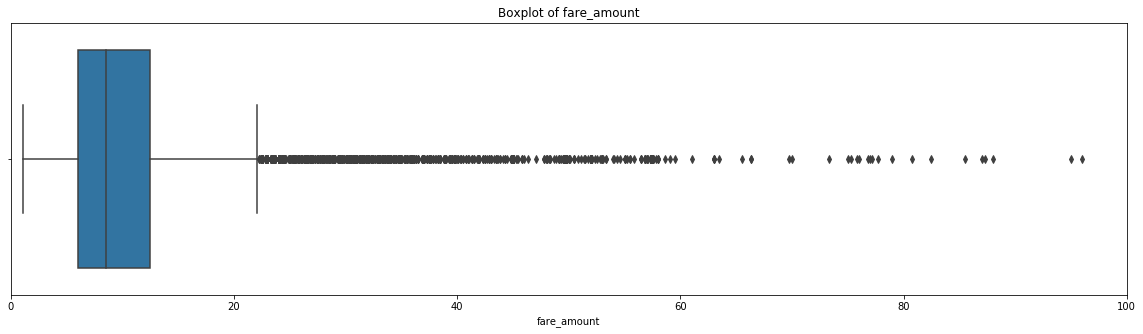

In [46]:
#Univariate Boxplots: Boxplots for all Numerical Variables including target variable

plt.figure(figsize=(20,5)) 
plt.xlim(0,100)
sns.boxplot(x=train['fare_amount'],data=train,orient='h')
plt.title('Boxplot of fare_amount')
# plt.savefig('bp of fare_amount.png')
plt.show()

In [47]:
#how the pickup_location affect the fare_amoun
#we first splitted the dataset into year,month,date,hour
data = [train, test]
#for i in data:
 #   i['Year'] = i ['pickup_datetime'].dt.year
  #  i['Month'] = i ['pickup_datetime'].dt.month
   # i['Date'] = i ['pickup_datetime'].dt.day
   #i['Day_of_week'] = i ['pickup_datetime'].dt.dayofweek
    #i['Hour'] = i ['pickup_datetime'].dt.hour

In [48]:
#Does the passenger_count (Number of Passengers) affect the fare_amount (fare)?

Text(0, 0.5, 'Frequency')

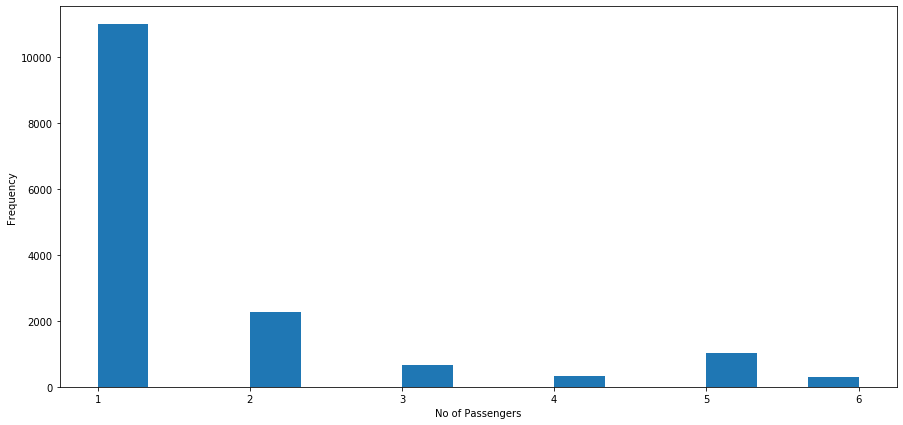

In [49]:
plt.figure(figsize = (15,7))
plt.hist(train['passenger_count'], bins=15)
plt.xlabel('No of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

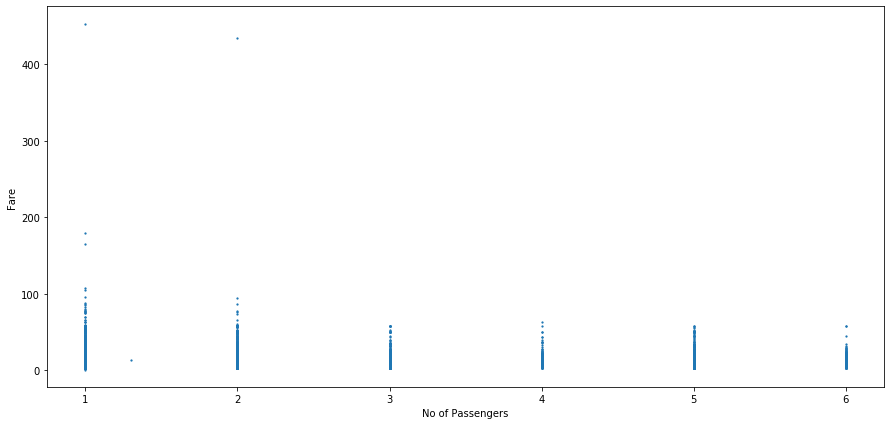

In [50]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['passenger_count'], y = train['fare_amount'], s=1.5)
plt.xlabel('No of Passengers')
plt.ylabel('Fare')# I see that single passenger is most frequent travellers, and highest fare also seems to come from cabs which carry just the 1 passenger

In [51]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'],errors='coerce')

In [52]:
train.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [53]:
train['pickup_year'] = train['pickup_datetime'].dt.year
train['pickup_month'] = train['pickup_datetime'].dt.month
train['pickup_date'] = train['pickup_datetime'].dt.day
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_Dayofweek'] = train['pickup_datetime'].dt.dayofweek
train['pickup_minute'] = train['pickup_datetime'].dt.minute

In [54]:
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'],errors='coerce')

In [55]:
test['pickup_year'] = test['pickup_datetime'].dt.year
test['pickup_month'] = test['pickup_datetime'].dt.month
test['pickup_date'] = test['pickup_datetime'].dt.day
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_Dayofweek'] = test['pickup_datetime'].dt.dayofweek
test['pickup_minute'] = test['pickup_datetime'].dt.minute

In [56]:
#calculate the distance travelled by cab from the pickup latutude & longitude and dropoff latutude & longitude


In [57]:
#Does the pickup_datetime (Pickup Date & Time) affect the fare_amount (fare)?

Text(0, 0.5, 'Fare')

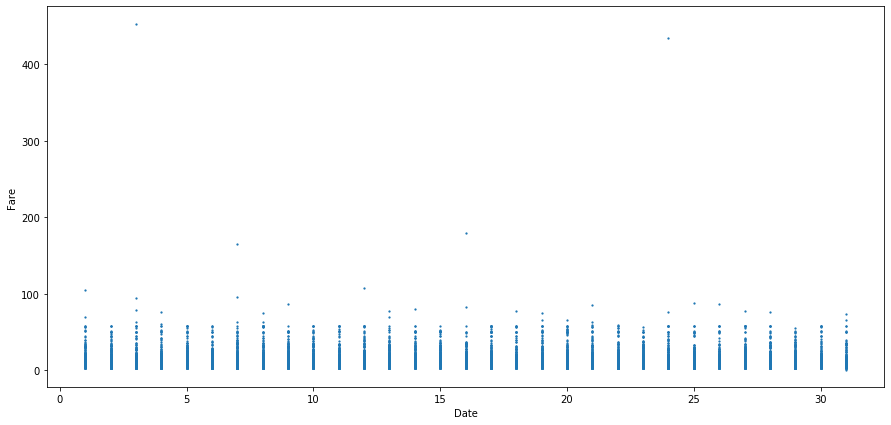

In [58]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['pickup_date'], y = train['fare_amount'], s=1.5)
plt.xlabel('Date')#does the pickupdate of month affect the fare_amount
plt.ylabel('Fare')#the fare_amount throughout the month is seem to be uniform, with maximum fare received on th 3rd

Text(0, 0.5, 'Frequency')

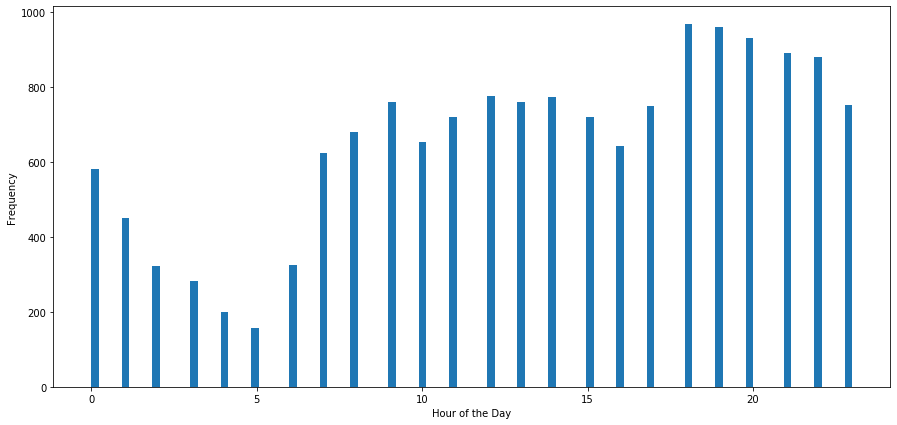

In [59]:
#does pickuptime of the day affect the fare_amount?
plt.figure(figsize = (15,7))
plt.hist(train['pickup_hour'], bins = 100)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')#The time of the day plays an important role. The frequency of cab rides seem to be lowest at 5AM and the highest at 6PM.

Text(0, 0.5, 'Fare')

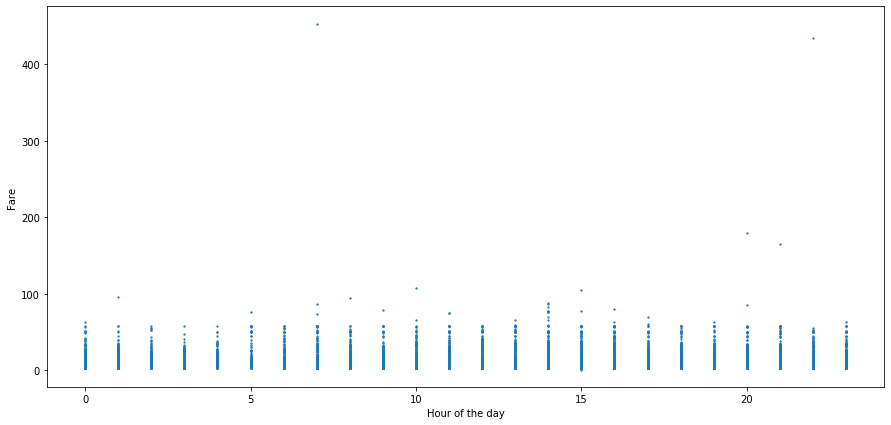

In [60]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['pickup_hour'], y = train['fare_amount'], s =1.5)
plt.xlabel('Hour of the day')
plt.ylabel('Fare')#The fares, seem to be the high between 5AM to 10AM and 1PM to 4PM. Maybe people who leave early to avoid traffic and cover large distance

In [61]:
#Does the distance travelled affect the fare_amount (fare)?

In [62]:
def harvesine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data: 
        R = 6371 #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
        
        delta_phi = np.radians(i[lat2] - i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
        
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2)* np.sin(delta_lambda/2.0)**2
        
        #c = 2 * arctan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
            #d = R * c
        d = (R * c) #distance in kilometers
        i['H_Distance'] = d
    return d

In [63]:
harvesine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323259
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183942
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [64]:
train['H_Distance'].head(10)

0     1.030764
1     8.450134
2     1.389525
3     2.799270
4     1.999157
5     3.787239
6     1.555807
7     4.155444
9     2.849627
10    1.374577
Name: H_Distance, dtype: float64

In [65]:
train.sort_values(['H_Distance', 'fare_amount'],ascending = False)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
10710,3.70,2011-02-11 21:46:09+00:00,-73.955411,39.604164,-73.955647,40.772837,1.0,2011,2,11,21,4,46,129.950482
14536,4.10,2011-04-03 12:16:46+00:00,-73.982155,40.775187,-73.976399,39.610030,1.0,2011,4,3,12,6,16,129.560455
11619,11.30,2011-05-27 21:47:44+00:00,-73.945106,39.603178,-73.976636,40.749643,1.0,2011,5,27,21,4,47,127.509261
12228,16.50,2011-04-26 23:18:56+00:00,-73.993360,40.721749,-73.977370,39.610604,2.0,2011,4,26,23,1,18,123.561157
5663,49.15,2009-02-25 07:05:05+00:00,-73.137393,41.366138,-74.000940,40.731723,1.0,2009,2,25,7,2,5,101.094619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8711,2.50,2013-01-02 09:33:21+00:00,-73.978626,40.744067,-73.978626,40.744067,1.0,2013,1,2,9,2,33,0.000000
9177,2.50,2010-12-06 11:48:34+00:00,-73.946993,40.744583,-73.946993,40.744583,3.0,2010,12,6,11,0,48,0.000000
9773,2.50,2013-03-29 18:45:53+00:00,-73.874439,40.773819,-73.874439,40.773819,1.0,2013,3,29,18,4,45,0.000000
10705,2.50,2013-09-13 16:14:28+00:00,-73.950813,40.771671,-73.950813,40.771671,1.0,2013,9,13,16,4,14,0.000000


Text(0, 0.5, 'Frequency')

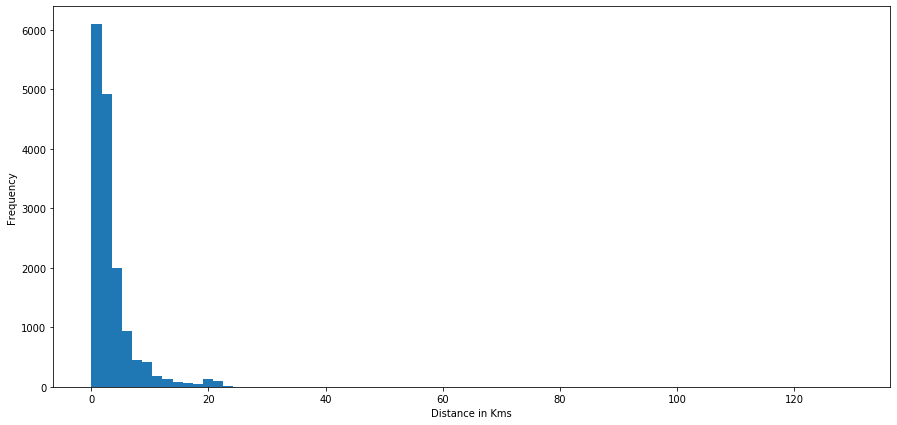

In [66]:
plt.figure(figsize = (15,7))
plt.hist(train['H_Distance'], bins=75)
plt.xlabel('Distance in Kms')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

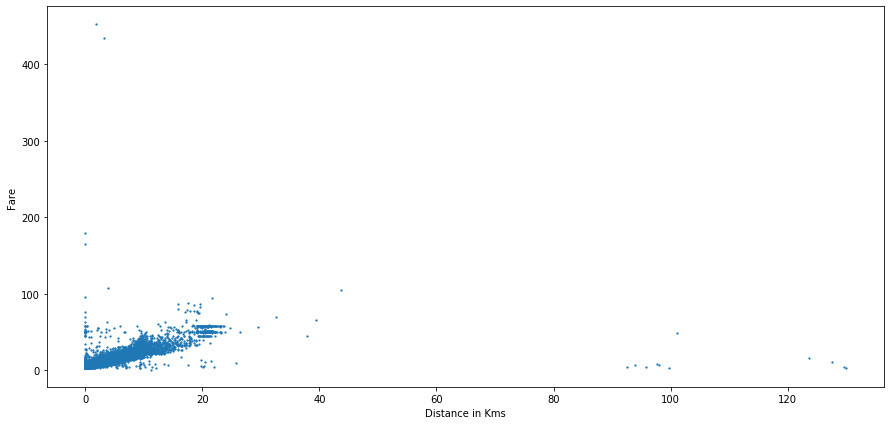

In [67]:
plt.figure(figsize = (15,7))
plt.scatter(x = train['H_Distance'], y = train['fare_amount'], s=1.5 )
plt.xlabel('Distance in Kms')
plt.ylabel('Fare')# as we see outliers here ater 50km we will drop them

In [68]:
train = train.drop(train[train['H_Distance']>50].index, axis =0) #11 observations dropped

In [69]:
train[train['H_Distance']==0]#The cab waited the whole time and passenger cancelled the trip after sometime. Thats the reason why the pickup and dropoff coordinates are same and maybe, passenger was charged for the waiting time.

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
105,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1.0,2009,3,25,0,2,8,0.0
191,6.5,2014-01-08 21:55:58+00:00,-73.998488,40.726303,-73.998488,40.726303,1.0,2014,1,8,21,2,55,0.0
270,7.5,2012-08-25 01:53:42+00:00,-73.995892,40.746454,-73.995892,40.746454,1.0,2012,8,25,1,5,53,0.0
290,6.9,2009-12-14 12:33:00+00:00,-73.982432,40.745747,-73.982432,40.745747,1.0,2009,12,14,12,0,33,0.0
396,12.0,2014-03-12 18:12:44+00:00,-73.844904,40.736318,-73.844904,40.736318,1.0,2014,3,12,18,2,12,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15738,8.5,2012-05-11 07:28:00+00:00,-73.937762,40.758157,-73.937762,40.758157,1.0,2012,5,11,7,4,28,0.0
15769,17.0,2012-12-21 20:35:18+00:00,-74.003743,40.756404,-74.003743,40.756404,1.0,2012,12,21,20,4,35,0.0
15869,6.9,2009-07-22 00:02:37+00:00,-73.941874,40.748985,-73.941874,40.748985,1.0,2009,7,22,0,2,2,0.0
15906,12.5,2011-11-20 12:58:00+00:00,-73.928838,40.616788,-73.928838,40.616788,2.0,2011,11,20,12,6,58,0.0


In [70]:
train = train.drop(train[train['H_Distance']==0].index, axis=0)

In [71]:
train.shape

(15404, 14)

In [72]:
test[test['H_Distance']==0]

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
121,2014-06-14 13:39:00+00:00,-73.980590,40.747682,-73.980590,40.747682,1.0,2014,6,14,13,5,39,0.0
279,2010-09-05 22:31:32+00:00,-74.047394,40.785789,-74.047394,40.785789,1.0,2010,9,5,22,6,31,0.0
318,2009-06-10 16:55:00+00:00,-73.985862,40.744027,-73.985862,40.744027,1.0,2009,6,10,16,2,55,0.0
417,2011-06-24 12:03:00+00:00,-73.964615,40.777620,-73.964615,40.777620,1.0,2011,6,24,12,4,3,0.0
423,2011-06-24 12:03:00+00:00,-73.955065,40.771505,-73.955065,40.771505,1.0,2011,6,24,12,4,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9478,2011-12-13 22:00:00+00:00,-73.946078,40.749467,-73.946078,40.749467,5.0,2011,12,13,22,1,0,0.0
9500,2014-07-21 18:19:00+00:00,-73.975767,40.752947,-73.975767,40.752947,5.0,2014,7,21,18,0,19,0.0
9563,2011-03-06 21:01:00+00:00,-73.990780,40.724202,-73.990780,40.724202,5.0,2011,3,6,21,6,1,0.0
9830,2014-07-21 18:19:00+00:00,-73.981425,40.773935,-73.981425,40.773935,6.0,2014,7,21,18,0,19,0.0


In [73]:
test = test.drop(test[test['H_Distance']==0].index, axis=0)

In [74]:
test.shape

(9829, 13)

In [75]:
BB_zoom = (-74.1, -73.7, 39.6, 39.85)
nyc_map_zoom = plt.imread('https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/images/nyc_-74.1_-73.7_40.6_40.85.PNG?raw=true')

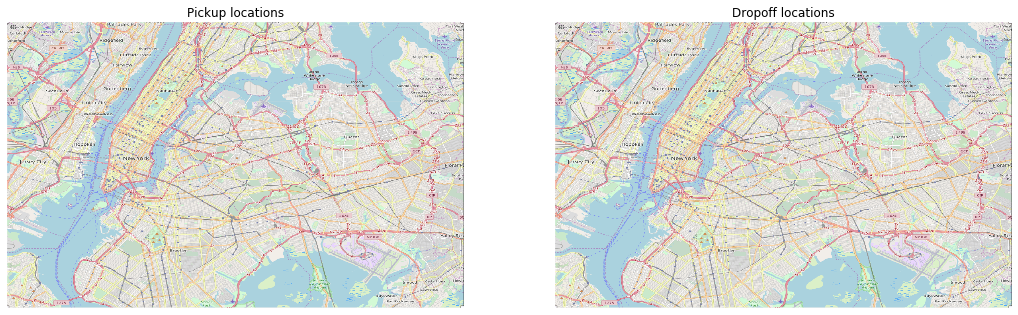

In [76]:
RSEED=100
def plot_on_map(train, BB, nyc_map, s=10, alpha=0.2, color = True):
    fig, axs = plt.subplots(1, 2, figsize=(18, 22))
    axs[0].scatter(train.pickup_longitude,train.pickup_latitude, zorder=1, alpha=alpha, c='b', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].axis('off')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(train.dropoff_longitude,train.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].axis('off')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)
    
# plot training data on map zoomed in
plot_on_map(train.sample(1_000, random_state = RSEED),BB_zoom, nyc_map_zoom, s=0.05, alpha=0.05)

# modelling and predicting

In [77]:
#Currently I am dealing with Regression Model So I am considering following algorithm models: #Linear Regression
#Decision Tree #Random Forest

In [78]:
#now we will be dropping datetime_pickup
train = train.drop(columns='pickup_datetime')
test = test.drop(columns='pickup_datetime')

In [79]:
X=train

In [80]:
X=X.iloc[:,-1]
X

0        1.030764
1        8.450134
2        1.389525
3        2.799270
4        1.999157
           ...   
16061    3.357490
16062    0.850044
16063    7.867638
16064    1.469105
16065    2.590036
Name: H_Distance, Length: 15404, dtype: float64

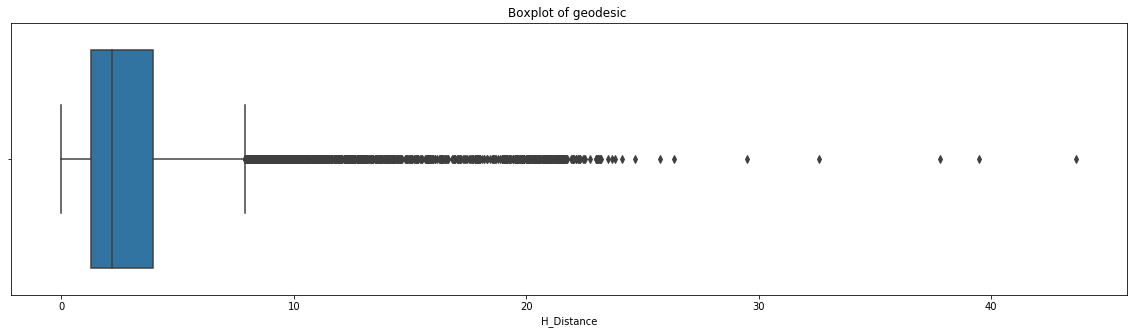

In [81]:
plt.figure(figsize=(20,5)) 
sns.boxplot(x=train['H_Distance'],data=train,orient='h')
plt.title('Boxplot of geodesic ')
# plt.savefig('bp geodesic.png')
plt.show()

In [82]:
y = train.iloc[:,0].values

In [83]:
y

array([ 4.5, 16.9,  5.7, ..., 16.1,  8.5,  8.1])

In [84]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_year,pickup_month,pickup_date,pickup_hour,pickup_Dayofweek,pickup_minute,H_Distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,17,0,26,1.030764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,16,1,52,8.450134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,0,3,35,1.389525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,4,5,30,2.799270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,7,1,51,1.999157


In [85]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y =train_test_split(X,y,test_size=0.3)

In [86]:
from sklearn import linear_model  # X is distance and y is fare
import statsmodels.api as sm

In [87]:
LR_model = linear_model.LinearRegression()

In [88]:
import numpy as np
train_X=np.array(train_X)
train_X=(train_X).reshape(-1,1)
LR_model.fit(train_X,train_y)

LinearRegression()

In [133]:
print(LR_model.intercept_)

3.678909949490408


In [135]:
score=LR_model.score(train_X,train_y)
score

0.6330448739403214

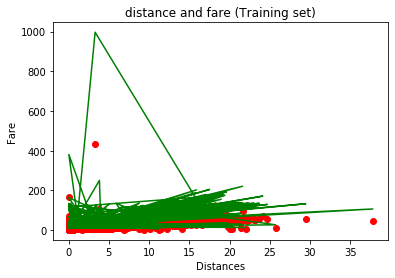

In [89]:
import matplotlib.pyplot as plt
plt.scatter(train_X,train_y, color = "red")
plt.plot(train_X,LR_model.predict(train_y.reshape(-1,1)), color = "green")
plt.title("distance and fare (Training set)")
plt.xlabel("Distances")
plt.ylabel("Fare")
plt.show()

In [90]:
test_X=np.array(test_X)
test_X=test_X.reshape(-1,1)
LR_predict = LR_model.predict(test_X)

In [91]:
LR_predict

array([ 8.50057772,  7.82804073,  7.98642918, ..., 10.8994273 ,
       11.77072293,  5.46847984])

In [92]:
#train the model using training dataset
model_LR = sm.OLS(train_y, train_X).fit()
predict_LR = model_LR.predict(test_X)
model_LR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.803
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                          4.398e+04
Date:                Mon, 06 Jun 2022   Prob (F-statistic):                        0.00
Time:                        17:49:53   Log-Likelihood:                         -36006.
No. Observations:               10782   AIC:                                  7.201e+04
Df Residuals:                   10781   BIC:                                  7.202e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7978      0.013    209.703      0.000       2.772       2.824
==============================================================================
Omnibus:                    27213.482   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1260782573.922
Skew:                          27.372   Prob(JB):                         0.00
Kurtosis:                    1677.342   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
#pickup_longitude, pickup_latitude, dropoff_latitude, year, month, hour, H_distance have small p-values, where as dropoff_longitude, passenger_count, date have a larger p-values
#Here I reject the null-hypothesis for pickup_longitude, pickup_latitude, dropoff_latitude, year, month, hour, H_distance
#* There is assicoation between these variables and fare_amount
#Fail to reject the null hypothesis for dropoff_longitude, passenger_count, date
#There is no association
#R-squared (0.848) means this model provides better fit for the given data

In [94]:
#here we used Error Metrics to evaluate the model
#Mean Absolute Error (MAE): is the mean of the absolute value of the errors: In [0,∞), the smaller the better
#Mean Squared Error (MSE): is the mean of the squared errors: In [0,∞), the smaller the better
#Mean Absolute Percent Error (MAPE): is the mean of the absolute percent value of the errors: In [0,1), the smaller the better
#Root Mean Squared Error (RMSE) :is the square root of the mean of the squared errors: In [0,∞), the smaller the bett

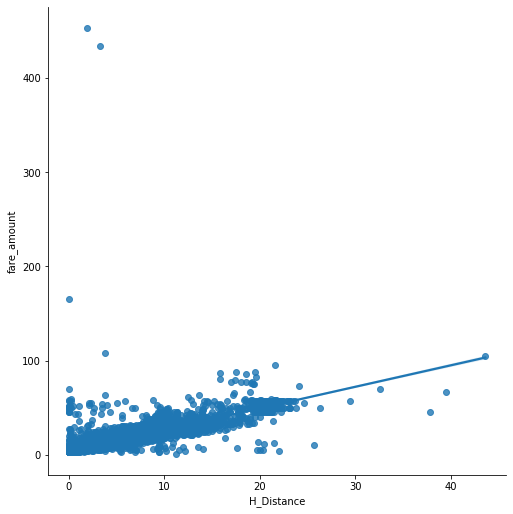

In [95]:
#plotting scatter pair plot H_Distance vs fare_amount
sns.pairplot(train, x_vars=['H_Distance'], y_vars='fare_amount', height = 7,kind='reg')

In [96]:
def MAPE(true_y, pred_y):
    mape = np.mean(np.abs(true_y-pred_y)/true_y)
    return mape

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# calculate MAE, MSE, MAPE, RMSE
print("MAE:",mean_absolute_error(test_y, predict_LR))
print("MSE:",mean_squared_error(test_y, predict_LR))
print("MAPE:",MAPE(test_y,predict_LR))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_LR)))


MAE: 3.2634233220197606
MSE: 67.38296064652843
MAPE: 0.32618003679239876
RMSE: 8.208712484094471


In [98]:
#DecisionTree

In [99]:
from sklearn.tree import DecisionTreeRegressor

In [100]:
model_DT = DecisionTreeRegressor(max_depth = 2).fit(train_X,train_y)
predict_DT = model_DT.predict(test_X)

In [136]:
score=model_DT.score(train_X,train_y)
score

0.6052749412254035

In [101]:
predict_DT

array([ 7.41261937,  7.41261937,  7.41261937, ...,  7.41261937,
       14.59295481,  7.41261937])

In [102]:
#from sklearn.externals.six import StringIO
from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [103]:
from graphviz import Digraph
import pydotplus

In [104]:
#pip install graphviz

In [105]:
#ip install pydotplus
dot_data = StringIO()
export_graphviz(model_DT,out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [106]:
print("MAE:",mean_absolute_error(test_y, predict_DT))
print("MSE:",mean_squared_error(test_y, predict_DT))
print("MAPE:",MAPE(test_y,predict_DT))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_DT)))

MAE: 3.01022007686135
MSE: 64.70926149194173
MAPE: 0.31335842403399466
RMSE: 8.044206703705576


In [138]:
from sklearn.ensemble import RandomForestRegressor

In [139]:
model_RF = RandomForestRegressor(n_estimators = 1000)

##train the model using training dataset
model_RF.fit(train_X, train_y)

RandomForestRegressor(n_estimators=1000)

In [144]:
model_RF.score(train_X,train_y)

0.9311913202318567

In [ ]:
predict_RF = model_RF.predict(test_X)
predict_RF

In [ ]:
estimator = model_RF.estimators_[5]

In [ ]:
import pydotplus
import six
from sklearn import tree

In [ ]:
dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in model_RF.estimators_:
    if (i_tree <1):
        tree.export_graphviz(tree_in_forest, out_file=dotfile)
        pydotplus.graph_from_dot_data(dotfile.getvalue()).write_png('dtree'+ str(i_tree) +'.png')
        i_tree = i_tree + 1

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',feature_names= train_X.feature_name,class_names =train_X,
                rounded = True, proportion = False,precision=2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [ ]:
print("MAE:",mean_absolute_error(test_y, predict_RF))
print("MSE:",mean_squared_error(test_y, predict_RF))
print("MAPE:",MAPE(test_y,predict_RF))
print("RMSE:",np.sqrt(mean_squared_error(test_y, predict_RF)))

In [145]:
# Ridge Regression

param_dist = {'alpha':np.logspace(-4, 0, 50),'normalize':[True,False],'max_iter':range(500,5000,500)}# Instantiate a Decision ridge classifier: ridge
ridge = Ridge()

# Instantiate the gridSearchCV object: ridge_cv
ridge_cv = GridSearchCV(ridge, param_dist, cv=5,scoring='r2')

# Fit it to the data
ridge_cv.fit(train_X, train_y)

# Print the tuned parameters and score
print("Tuned Decision ridge Parameters: {}".format(ridge_cv.best_params_))
print("Best score is {}".format(ridge_cv.best_score_))

Tuned Decision ridge Parameters: {'alpha': 0.0001, 'max_iter': 500, 'normalize': False}
Best score is 0.6777339195471571


In [147]:
predict_ridge = ridge_cv.predict(test_X)
predict_ridge

array([ 8.50057772,  7.82804074,  7.98642918, ..., 10.8994273 ,
       11.77072293,  5.46847984])

In [ ]:
def rmsle(y,y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in train_y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))
def scores(y, y_):
    print('r square  ', metrics.r2_score(y, y_))
    print('Adjusted r square:{}'.format(1 - (1-metrics.r2_score(y, y_))*(len(y)-1)/(len(y)-X_train.shape[1]-1)))
    print('MAPE:{}'.format(np.mean(np.abs((y - y_) / y))*100))
    print('MSE:', metrics.mean_squared_error(y, y_))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y, y_))) 
def test_scores(model):
    print('<<<------------------- Training Data Score --------------------->')
    print()
    #Predicting result on Training data
    y_pred = model.predict(X_train)
    scores(y_train,y_pred)
    print('RMSLE:',rmsle(y_train,y_pred))
    print()
    print('<<<------------------- Test Data Score --------------------->')
    print()
    # Evaluating on Test Set
    y_pred = model.predict(test)
    scores(y_test,y_pred)
    print('RMSLE:',rmsle(y_test,y_pred))

In [ ]:
#MAPE for model evaluatiomn becasue, it calculate average absolute percent error for each time period minus actual values divided by actual values.
#Random Forest Model has smallest error metrics i.e.
#MAPE = 0.214435
#So, for further analysis I am selecting Random Forest Model.

In [ ]:
test.shape

In [107]:
scaler = preprocessing.MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_X)
validation_df_scaled = scaler.fit_transform(test_X)

In [108]:
validation_df_scaled

array([[0.04826999],
       [0.04153608],
       [0.04312198],
       ...,
       [0.07228892],
       [0.08101294],
       [0.01791053]])

In [109]:
train_X

array([[1.11960003],
       [2.81450303],
       [3.16398273],
       ...,
       [0.65245418],
       [2.66919126],
       [4.51537662]])

In [119]:
test_scaled = scaler.fit_transform(test)

In [182]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=1)
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1))

#adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer='adam', metrics=['mae','mse'])

SyntaxError: invalid syntax (<ipython-input-182-5baf9d6f4044>, line 3)

In [174]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               512       
_________________________________________________________________
batch_normalization_20 (Batc (None, 256)               1024      
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_21 (Batc (None, 128)               512       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_22 (Batc (None, 64)                256       
_________________________________________________________________
dense_27 (Dense)             (None, 32)               

In [175]:
print(train_df_scaled.shape)

(10782, 1)


In [176]:
print(test_scaled.shape)
print(y.shape)
print(validation_df_scaled.shape)

(9829, 12)
(15404,)
(4622, 1)


In [177]:
history=model.fit(x=train_X,y=train_y,batch_size=256,epochs=150,verbose=1,shuffle=True)

Epoch 1/150
43/43 [==============================] - 0s 5ms/step - loss: 38.6979 - mae: 2.4810 - mse: 38.5999
Epoch 2/150
43/43 [==============================] - 0s 6ms/step - loss: 38.8735 - mae: 2.4559 - mse: 38.7759
Epoch 3/150
43/43 [==============================] - 0s 6ms/step - loss: 38.5792 - mae: 2.4493 - mse: 38.4837
Epoch 4/150
43/43 [==============================] - 0s 6ms/step - loss: 38.5680 - mae: 2.4446 - mse: 38.4731
Epoch 5/150
43/43 [==============================] - 0s 6ms/step - loss: 38.9691 - mae: 2.4808 - mse: 38.8748
Epoch 6/150
43/43 [==============================] - 0s 6ms/step - loss: 38.6716 - mae: 2.4560 - mse: 38.5779
Epoch 7/150
43/43 [==============================] - 0s 6ms/step - loss: 39.2489 - mae: 2.5000 - mse: 39.1581
Epoch 8/150
43/43 [==============================] - 0s 6ms/step - loss: 38.5954 - mae: 2.4544 - mse: 38.5032
Epoch 9/150
43/43 [==============================] - 0s 6ms/step - loss: 38.6530 - mae: 2.4544 - mse: 38.5582
Epoch 10/1

43/43 [==============================] - 0s 6ms/step - loss: 38.6600 - mae: 2.4679 - mse: 38.5755
Epoch 74/150
43/43 [==============================] - 0s 6ms/step - loss: 38.4219 - mae: 2.4520 - mse: 38.3412
Epoch 75/150
43/43 [==============================] - 0s 5ms/step - loss: 38.7572 - mae: 2.4495 - mse: 38.6743
Epoch 76/150
43/43 [==============================] - 0s 5ms/step - loss: 38.4092 - mae: 2.4385 - mse: 38.3299
Epoch 77/150
43/43 [==============================] - 0s 6ms/step - loss: 38.5095 - mae: 2.4437 - mse: 38.4276
Epoch 78/150
43/43 [==============================] - 0s 6ms/step - loss: 38.4274 - mae: 2.4401 - mse: 38.3453
Epoch 79/150
43/43 [==============================] - 0s 5ms/step - loss: 38.7769 - mae: 2.4690 - mse: 38.6978
Epoch 80/150
43/43 [==============================] - 0s 7ms/step - loss: 38.4923 - mae: 2.4556 - mse: 38.4106
Epoch 81/150
43/43 [==============================] - 0s 6ms/step - loss: 38.7678 - mae: 2.4374 - mse: 38.6864
Epoch 82/150
4

43/43 [==============================] - 0s 5ms/step - loss: 38.1178 - mae: 2.4437 - mse: 38.0364
Epoch 145/150
43/43 [==============================] - 0s 5ms/step - loss: 38.4812 - mae: 2.4418 - mse: 38.3998
Epoch 146/150
43/43 [==============================] - 0s 5ms/step - loss: 38.6427 - mae: 2.4456 - mse: 38.5648
Epoch 147/150
43/43 [==============================] - 0s 5ms/step - loss: 38.6078 - mae: 2.4601 - mse: 38.5318
Epoch 148/150
43/43 [==============================] - 0s 5ms/step - loss: 38.4505 - mae: 2.4291 - mse: 38.3719
Epoch 149/150
43/43 [==============================] - 0s 5ms/step - loss: 38.2678 - mae: 2.4365 - mse: 38.1877
Epoch 150/150
43/43 [==============================] - 0s 6ms/step - loss: 38.7176 - mae: 2.4587 - mse: 38.6412


In [ ]:
y=np.logical_and(,test_scaled),

In [170]:
#plot_loss_accuracy(history)
prediction = model.predict(test_X, batch_size=128, verbose=1)
prediction

37/37 [==============================] - 0s 1ms/step


array([[12.299205],
       [14.031238],
       [13.56243 ],
       ...,
       [11.380262],
       [11.781883],
       [11.792266]], dtype=float32)

In [171]:
test_y

array([ 6.5,  7.3,  8. , ..., 10.5, 11. ,  4.5])

In [179]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
MSE = mean_squared_error(test_y,prediction)
MSE**(0.5)

8.98982195194455

In [181]:
MAPE(test_y,prediction)

1.0355091853279006

In [10]:
#!pip install geopy

In [143]:
import geopy
from geopy import distance
from geopy.geocoders import Nominatim

In [149]:
geocoder=Nominatim(user_agent="Lalit")
for i in range(1):
    location1=input("Enter the pickup location")
    location2=input("Enter the dropoff location")
    t=input("Enter the waiting time")
coordinates1=geocoder.geocode(location1)
coordinates2=geocoder.geocode(location2)
lat1,long1=(coordinates1.latitude,coordinates1.longitude)
lat2,long2=(coordinates2.latitude,coordinates2.longitude)
place1=(lat1,long1)
place2=(lat2,long2)
dis=distance.distance(place1,place2)
print("The calculated distance between the 2 places is",dis)

Enter the pickup locationKalpakkam
Enter the dropoff locationChennai Central
Enter the waiting time1
The calculated distance between the 2 places is 64.70058189193598 km


In [ ]:
225 Park Ave S, New York, NY 10003, United States
8 Extra Pl, New York, NY 10003, United States

In [145]:
dis=np.array(float(str(dis)[:-3])).reshape(-1,1)

In [146]:
LR_model.predict(dis)

array([14.00671396])

In [147]:
model_DT.predict(dis)

array([14.53499188])

In [6]:
#the first km is 50 rs
#every additional km is 7rs 
#and every minute of waiting is 2.5rs. 

start=50
if dis <=10:
    print("The price will be",(dis*7)+start)
else:
    print("The price is ",50+(7*(dis-1))+(float(t)*2.5))


The price is  155.26687021211728


In [429]:
import osmnx as ox
import networkx as nx

ModuleNotFoundError: No module named 'osmnx'

In [430]:
pip install osmnx

    ERROR: Command errored out with exit status 1:
     command: 'C:\Users\lalit\anaconda3\python.exe' -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\lalit\\AppData\\Local\\Temp\\pip-install-1zfe9dap\\fiona\\setup.py'"'"'; __file__='"'"'C:\\Users\\lalit\\AppData\\Local\\Temp\\pip-install-1zfe9dap\\fiona\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\lalit\AppData\Local\Temp\pip-install-1zfe9dap\fiona\pip-egg-info'
         cwd: C:\Users\lalit\AppData\Local\Temp\pip-install-1zfe9dap\fiona\
    Complete output (1 lines):
    A GDAL API version must be specified. Provide a path to gdal-config using a GDAL_CONFIG environment variable or use a GDAL_VERSION environment variable.
    ----------------------------------------
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for fu

Note: you may need to restart the kernel to use updated packages.


In [446]:
#from tabgan.sampler import OriginalGenerator
from tabgan.sampler import GANGenerator

ContextualVersionConflict: (pandas 1.0.1 (c:\users\lalit\anaconda3\lib\site-packages), Requirement.parse('pandas>=1.0.5'), {'category-encoders'})

In [443]:
#pip install tabgan

Note: you may need to restart the kernel to use updated packages.


In [ ]:
new_train1,new_target1=OriginalGenerator().generate_data_pipe(train_X,train_y,test_scaled)
new_train2,new_target2=GANGenerator().generate_data_pipe(train_X,train_y,test_scaled)